In [17]:
import numpy as np 
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
data_train = pd.read_csv(os.path.join("..", "data", "revalidated", "data_train_f_001.csv"))
data_train.head()

,path,label,conf,revalidated_manually
0,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000,1
1,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000,1
2,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.444923,1
3,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.616470,1
4,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000,1


In [3]:
sys.path.append(os.path.abspath(os.path.join('..', 'datasets')))

In [4]:
from custom_dataset import CustomImageDataset

In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
image_paths = data_train['path'].values.tolist()
labels = data_train['label'].values.tolist()

dataset = CustomImageDataset(image_paths=image_paths, labels=labels, transform=transform)

In [14]:
dataset.image_paths[:5]

['..\\.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame001.jpg',
 '..\\.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame002.jpg',
 '..\\.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame003.jpg',
 '..\\.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame004.jpg',
 '..\\.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame005.jpg']

In [15]:
features, labels = dataset.to_numpy()

In [20]:
features.shape, labels.shape

((4294, 49152), (4294,))

In [21]:
features[0].shape

(49152,)

In [22]:
def display_image_from_flattened(flattened_image, height, width, channels=3):
    image_reshaped = flattened_image.reshape(channels, height, width)
    image_numpy = np.transpose(image_reshaped, (1, 2, 0))
    plt.imshow(image_numpy)
    plt.axis('off')  
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069099..2.3785625].


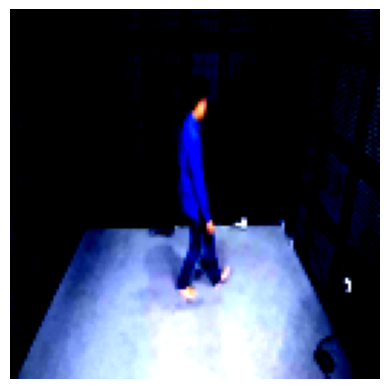

In [23]:
display_image_from_flattened(features[0], 128, 128)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [65]:
pipeline_with_pca = Pipeline([
    ('pca', PCA(n_components=100)),  
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))  
])

pipeline_without_pca = Pipeline([  
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))  
])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [67]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [68]:
pipeline_with_pca.fit(X_train_resampled, y_train_resampled)
pipeline_without_pca.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('rf', RandomForestClassifier(random_state=42))])

In [69]:
# Prediksi menggunakan pipeline dengan PCA
y_pred_with_pca = pipeline_with_pca.predict(X_test)

# Prediksi menggunakan pipeline tanpa PCA
y_pred_without_pca = pipeline_without_pca.predict(X_test)

# Evaluasi hasil prediksi
accuracy_with_pca = accuracy_score(y_test, y_pred_with_pca)
accuracy_without_pca = accuracy_score(y_test, y_pred_without_pca)

print(f"Accuracy with PCA: {accuracy_with_pca:.4f}")
print(f"Accuracy without PCA: {accuracy_without_pca:.4f}")


Accuracy with PCA: 0.9849
Accuracy without PCA: 0.9895


In [70]:
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix with PCA:")
print(confusion_matrix(y_test, y_pred_with_pca))
print("Classification Report with PCA:")
print(classification_report(y_test, y_pred_with_pca))

print("Confusion Matrix without PCA:")
print(confusion_matrix(y_test, y_pred_without_pca))
print("Classification Report without PCA:")
print(classification_report(y_test, y_pred_without_pca))

Confusion Matrix with PCA:
[[541   5]
 [  8 305]]
Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       546
           1       0.98      0.97      0.98       313

    accuracy                           0.98       859
   macro avg       0.98      0.98      0.98       859
weighted avg       0.98      0.98      0.98       859

Confusion Matrix without PCA:
[[544   2]
 [  7 306]]
Classification Report without PCA:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       546
           1       0.99      0.98      0.99       313

    accuracy                           0.99       859
   macro avg       0.99      0.99      0.99       859
weighted avg       0.99      0.99      0.99       859



In [32]:
from sklearn.model_selection import cross_val_score

In [44]:
cv_scores_with_pca = cross_val_score(pipeline_with_pca, features, labels, cv=10)
print(f"Cross-validation scores with PCA: {cv_scores_with_pca}")
print(f"Mean cross-validation score with PCA: {cv_scores_with_pca.mean()}")

Cross-validation scores with PCA: [0.48604651 0.78604651 0.69534884 0.74883721 0.76456876 0.82284382
 0.79254079 0.80885781 0.68764569 0.54079254]
Mean cross-validation score with PCA: 0.713352848701686


In [45]:
cv_scores_without_pca = cross_val_score(pipeline_without_pca, features, labels, cv=10)
print(f"Cross-validation scores without PCA: {cv_scores_without_pca}")
print(f"Mean cross-validation score without PCA: {cv_scores_without_pca.mean()}")

Cross-validation scores without PCA: [0.4372093  0.78372093 0.58139535 0.6372093  0.94871795 0.6969697
 0.79254079 0.76923077 0.70862471 0.82983683]
Mean cross-validation score without PCA: 0.7185455629641677


In [46]:
test_data = pd.DataFrame({
    "id": os.listdir("../data/test")
})

test_data.head()

,id
0,00396960ae.jpg
1,004773d4e8.jpg
2,009b266d98.jpg
3,009ed56c89.jpg
4,00a16cb3ae.jpg


In [47]:
test_dataset = CustomImageDataset(image_paths=test_data['id'].values.tolist(), labels=None, transform=transform)

In [49]:
test_features, _ = test_dataset.to_numpy()

In [62]:
test_data['label'] = pipeline_with_pca.predict(test_features)

In [64]:
test_data['label'].sum()

np.int64(69)

In [60]:
pd.read_csv("../data/submissions/001.csv")['label'].sum()

np.int64(803)

In [72]:
test_data.to_csv('../data/submissions/005.csv', index=False)